## Import Libraries 

In [246]:
# Import Lib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import math
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

%matplotlib inline

# Importing the dataset
dataset_train = pd.read_csv('train.csv', header=None)
dataset_test = pd.read_csv('test.csv', header=None)
header = ['Age','Workclass','fnlwgt','Education','Education-num','Marital-status','Occupation','\
Relationship','Race','Sex','Capital-gain','Capital-loss','Hours-per-week','Native-country','Income']
dataset_train = pd.DataFrame(dataset_train.values, columns = header) 
dataset_test = pd.DataFrame(dataset_test.values, columns = header[:-1]) 

# Take all columns except last one
train = dataset_train.iloc[:, :-1]
test = dataset_test.iloc[:, :]
y = dataset_train.iloc[:, dataset_train.shape[1]-1]
y = y.astype(int)
print(dataset_train.shape)

(31654, 15)


## Data Analysis

In [233]:
dataset_train

,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,37,Private,272950,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,0
1,31,Private,261943,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,0
2,29,Private,285419,12th,8,Never-married,Tech-support,Not-in-family,White,Male,0,0,40,United-States,0
3,40,Private,182217,Some-college,10,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,Scotland,0
4,52,State-gov,71344,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0
5,49,Self-emp-inc,201080,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,0,0,55,United-States,0
6,21,Private,122048,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,29,United-States,0
7,61,Self-emp-not-inc,221884,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,1
8,25,Self-emp-not-inc,108001,9th,5,Never-married,Craft-repair,Not-in-family,White,Male,0,0,15,United-States,0
9,47,Private,171751,HS-grad,9,Divorced,Sales,Not-in-family,White,Female,0,0,40,United-States,0


(31654, 15)


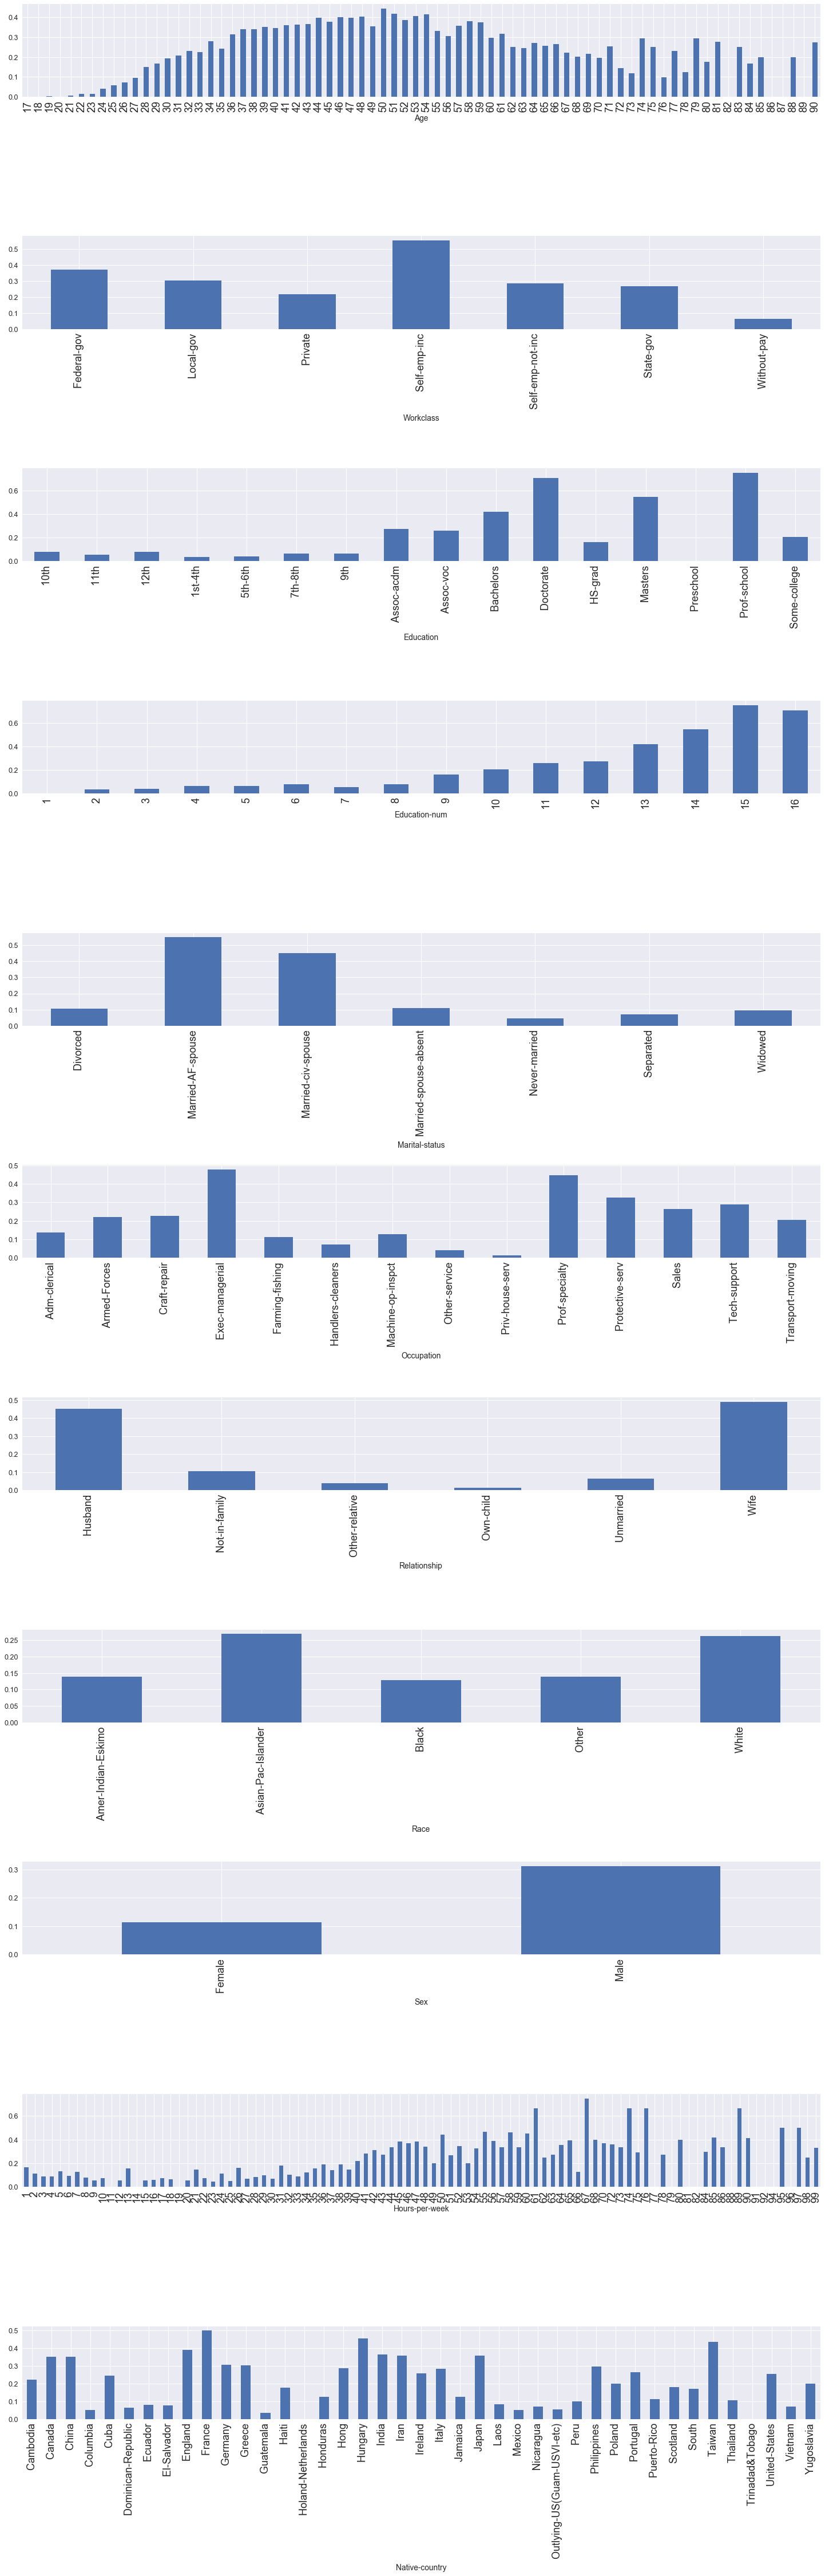

In [234]:
matplotlib.rcParams.update({'xtick.labelsize': 18})
#print(list(dataset_train)[0])
fig = plt.figure(figsize=(25,100))
fig.subplots_adjust(hspace = 1.5)
now = 1
for i in range(14):
    if i!=2 and i!=10 and i!=11:
        plt.subplot(14, 1, now)
        now += 1
        key = list(dataset_train)[i]
        
        group = dataset_train.groupby(key)['Income'].sum() / dataset_train.groupby(key)['Income'].size()
        group.plot(kind='bar')
        
print(dataset_train.shape)

## Data preprocessing

In [235]:
# Encoding categorial data
# Replace string by categories number
drop = []
train_objs_num = len(train)

dataset = train.append(test)
print(train.shape)
print(test.shape)
print(dataset.shape)

# Salary Mapping
edu_mapping = {
        ' Preschool':0, 
        ' 1st-4th':8,
        ' 5th-6th':8,
        ' 7th-8th':8,
        ' 9th':8,
        ' 10th':8,
        ' 11th':8,
        ' 12th':8,
        ' HS-grad':18,
        ' Prof-school':65,
        ' Assoc-acdm':25,
        ' Assoc-voc':25,
        ' Some-college':20,
        ' Bachelors':40,
        ' Masters':45,
        ' Doctorate':65
}
gender_mapping = {
    ' Female':10,
    ' Male':30
}
color_mapping = {
    ' Amer-Indian-Eskimo':1,
    ' White':4, 
    ' Asian-Pac-Islander':3, 
    ' Other':0, 
    ' Black':2
}
marital_mapping={
    ' Married-civ-spouse':45,
    ' Divorced':10,
    ' Never-married':5,
    ' Separated':10,
    ' Widowed':10,
    ' Married-spouse-absent':10,
    ' Married-AF-spouse':50
}
relation_mapping={
    ' Wife':45,
    ' Husband':45,
    ' Own-child':5,
    ' Otherrelative':5,
    ' Not-in-family':10,
    ' Unmarried':10
}
#['Age','Workclass','fnlwgt','Education','Education-num','Marital-status','Occupation',' \
#                     Relationship','Race','Sex','Capital-gain','Capital-loss','Hours-per-week','Native-country','Income']
dataset['Education'] = dataset['Education'].map(edu_mapping)
dataset['Sex'] = dataset['Sex'].map(gender_mapping)
dataset['Race'] = dataset['Race'].map(color_mapping)
dataset['Marital-status'] = dataset['Marital-status'].map(marital_mapping)

#income_minus = dataset.values[:,10] - dataset.values[:,11]
#min_value = min(income_minus)
#dataset['Capital-gain'] = (income_minus.astype(int))
# One hot encoder
'''
for row in range(0, dataset.shape[1]):
    if (isinstance(dataset.values[1][row], str)):        
        print ("Delete row: ", row), 
        one_hot = pd.get_dummies(dataset[row])
        drop.append(row)
        dataset = pd.concat([dataset, one_hot], axis=1)
        dataset = dataset.iloc[:, :-1]
    
# Remove original attributes
drop.sort(reverse=True)
for row in drop:
    dataset = dataset.drop(row, axis = 1)
'''

# Only label encoder
for row in range(0, dataset.shape[1]):
    if (isinstance(dataset.values[1][row], str)): 
        print (row),
        labelencoder = LabelEncoder()
        target = labelencoder.fit_transform(dataset.values[:, row])
        key = list(dataset)[row]
        dataset[key] = target
#dataset = dataset.drop('Capital-loss', axis = 1)
print(dataset.shape)
print ("Finish One Hot Enconding")

for row in range(0, dataset.shape[1]):
    key = list(dataset)[row]
    dataset[key] = dataset[key].astype(int)
# PCA
'''
n_com = 30
pca = PCA(n_components=n_com)
dataset_pca = pca.fit_transform(dataset)
print ("Finish PCA preprocess") 
'''

(31654, 14)
(13568, 14)
(45222, 14)
1
6
7
13
(45222, 14)
Finish One Hot Enconding


'\nn_com = 30\npca = PCA(n_components=n_com)\ndataset_pca = pca.fit_transform(dataset)\nprint ("Finish PCA preprocess") \n'

In [236]:
X = dataset[:train_objs_num]
X = pd.concat([X,dataset_train['Income']], axis = 1) 
print(X.shape)
X

(31654, 15)


,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,37,2,272950,18,9,45,3,0,4,30,0,0,40,38,0
1,31,2,261943,20,10,45,3,0,4,30,0,0,40,38,0
2,29,2,285419,8,8,5,12,1,4,30,0,0,40,38,0
3,40,2,182217,20,10,45,7,5,4,10,0,0,40,33,0
4,52,5,71344,45,14,45,9,0,4,30,0,0,40,38,0
5,49,3,201080,20,10,10,2,1,4,30,0,0,55,38,0
6,21,2,122048,20,10,5,0,3,4,10,0,0,29,38,0
7,61,4,221884,20,10,45,0,0,4,30,0,0,50,38,1
8,25,4,108001,8,5,5,2,1,4,30,0,0,15,38,0
9,47,2,171751,18,9,10,11,1,4,10,0,0,40,38,0


(31654, 15)
<class 'pandas.core.series.Series'> <class 'numpy.int32'>
<class 'pandas.core.series.Series'> <class 'numpy.int32'>


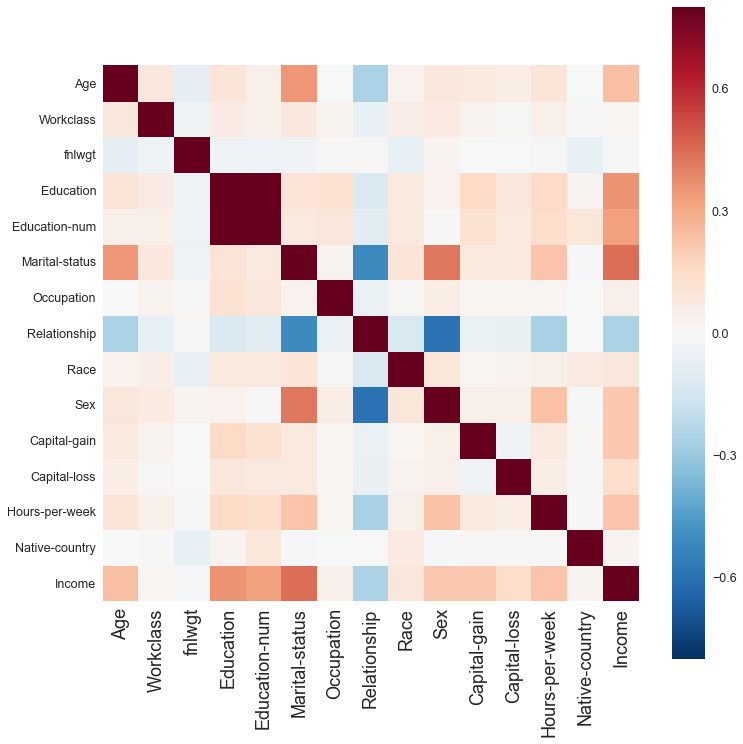

In [237]:
#correlation matrix
print(X.shape)
X = dataset[:train_objs_num]
X = pd.concat([X,dataset_train['Income']], axis = 1) 
X['Income'] = X['Income'].astype(int)

print(type(X['Age']), type(X['Age'][0]))
print(type(X['Education']), type(X['Education'][0]))
#print(X['Age'].corr(X['Education']))

corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True);


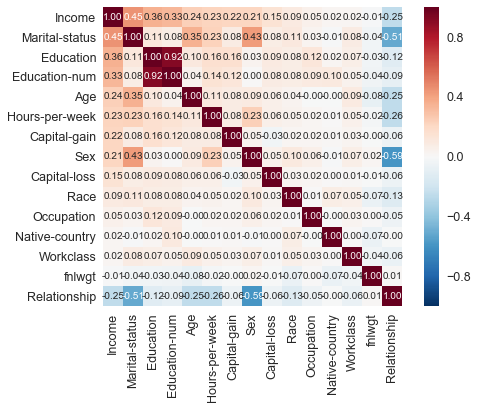

In [238]:
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Income')['Income'].index
cm = np.corrcoef(X[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [239]:
#['Age','Workclass','fnlwgt','Education','Education-num','Marital-status','Occupation',' \
#                     Relationship','Race','Sex','Capital-gain','Capital-loss','Hours-per-week','Native-country','Income']
print(dataset.columns)
dataset_preprocess = dataset.copy()
dataset_preprocess = dataset_preprocess.drop('Education-num', axis = 1)
dataset_preprocess = dataset_preprocess.drop('fnlwgt', axis = 1)
dataset_preprocess = dataset_preprocess.drop('Workclass', axis = 1)
dataset_preprocess = dataset_preprocess.drop('Native-country', axis = 1)
dataset_preprocess = dataset_preprocess.drop('Occupation', axis = 1)
dataset_preprocess = dataset_preprocess.drop('Race', axis = 1)
###
#dataset_preprocess = dataset_preprocess.drop('Sex', axis = 1)
#dataset_preprocess = dataset_preprocess.drop('Capital-gain', axis = 1)
#dataset_preprocess = dataset_preprocess.drop('Relationship', axis = 1)
#dataset_preprocess = dataset_preprocess.drop('Age', axis = 1)
#dataset_preprocess = dataset_preprocess.drop('Hours-per-week', axis = 1)
print(dataset_preprocess.columns)
print(dataset_preprocess.shape)

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-num',
       'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-country'],
      dtype='object')
Index(['Age', 'Education', 'Marital-status', 'Relationship', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week'],
      dtype='object')
(45222, 8)


## XGBOOST

In [212]:
X = dataset_preprocess[:train_objs_num]
test_data = dataset_preprocess[train_objs_num:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

xgbc = XGBClassifier(max_depth=10, learning_rate= 0.2)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)

#scores = cross_val_score(xgbc, X_train, y_train, cv=10, scoring='accuracy')
#print (scores)

print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, xgbc.predict(X_train)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std_pred = xgbc.predict(test_data)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")

Misclassified sample 925
Train Accuracy:  0.884768787268
Test Accuracy:  0.853893539725
precision:  0.853893539725
recall:  0.853893539725
fscore:  0.853893539725
Done


## SVM

In [105]:
X = dataset_preprocess[:train_objs_num]
test_data = dataset_preprocess[train_objs_num:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

#feature normalize
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

svm = SVC(kernel='rbf')
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)

print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, svm.predict(X_train_std)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std = sc.transform(test_data)
test_std_pred = svm.predict(test_std)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")

Misclassified sample 510
Train Accuracy:  0.840178320696
Test Accuracy:  0.838913455464
precision:  0.838913455464
recall:  0.838913455464
fscore:  0.838913455464
Done


## Random Forest Tree

In [106]:
X = dataset_preprocess[:train_objs_num]
test_data = dataset_preprocess[train_objs_num:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
'''
max_fscore = 0
target_n_estimators = 0
for i in range(10, 100):
    forest = RandomForestClassifier(criterion='entropy', n_estimators=i)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
    if fscore > max_fscore:
        max_fscore = fscore
        target_n_estimators = i
'''    
forest = RandomForestClassifier(criterion='entropy', n_estimators=20)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, forest.predict(X_train)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std_pred = forest.predict(test_data)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")

Misclassified sample 1058
Train Accuracy:  0.918374600166
Test Accuracy:  0.832885800032
precision:  0.832885800032
recall:  0.832885800032
fscore:  0.832885800032
Done


## Logistic Regression

In [186]:
X = dataset_preprocess[:train_objs_num]
test_data = dataset_preprocess[train_objs_num:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
logreg = LogisticRegression(C=1.01, solver='lbfgs', multi_class='multinomial', penalty = 'l2')
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

logreg.fit(X_train_std, y_train)
y_pred = logreg.predict(X_test_std)
print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, logreg.predict(X_train_std)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std_pred = logreg.predict(test_data)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")


Misclassified sample 494
Train Accuracy:  0.835790508284
Test Accuracy:  0.843967150979
precision:  0.843967150979
recall:  0.843967150979
fscore:  0.843967150979
Done


## Bagging

In [217]:
X = dataset_preprocess[:train_objs_num]
test_data = dataset_preprocess[train_objs_num:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

bag = BaggingClassifier(n_estimators = 20)
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

#scores = cross_val_score(xgbc, X_train, y_train, cv=10, scoring='accuracy')
#print (scores)

print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, bag.predict(X_train)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std_pred = bag.predict(test_data)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")

Misclassified sample 1044
Train Accuracy:  0.91699245745
Test Accuracy:  0.835097141052
precision:  0.835097141052
recall:  0.835097141052
fscore:  0.835097141052
Done


## NN

In [271]:
import tensorflow as tf
X = dataset_preprocess.iloc[:train_objs_num]
test_data = dataset_preprocess.iloc[train_objs_num:]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

y_train = y_train.iloc[:].values
y_test = y_test.iloc[:].values

print(y_train.shape)
def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

n_hidden_1 = 38
n_input = X_train_std.shape[1]

n_classes = 2

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

training_epochs = 1000
display_step = 100
batch_size = 32

x = tf.placeholder("float", [None, n_input])
y_ = tf.placeholder("float", [None, n_classes])
predictions = multilayer_perceptron(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y_))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(X_train_std) / batch_size)
        x_batches = np.array_split(X_train_std, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            print(type(batch_x))
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y_: batch_y, 
                                keep_prob: 0.8
                            })
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: X_test_std, y_: y_test, keep_prob: 1.0}))

(28488,)
<class 'numpy.ndarray'>


ValueError: Cannot feed value of shape (33,) for Tensor 'Placeholder_74:0', which has shape '(?, 1)'